# Imports

In [3]:
from orbit_generation.data import load_memmap_array,get_orbit_features
from orbit_generation.processing import resample_3d_array, plot_histograms_comparison, plot_latent_space
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits

In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tensorflow import keras
import tsgm

2024-05-07 11:33:49.333520: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 11:33:49.356775: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 11:33:49.356795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 11:33:49.357361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 11:33:49.361244: I tensorflow/core/platform/cpu_feature_guar

# Parameters

In [ ]:
model_name= 'vae'
folder_out = ""
data_used = ""

In [ ]:
latent_dim = 32
feature_dim = 7
seq_len = 300 # CHECK!!!!
batch_size = 32
epochs = 50 # CHECK!!!!

# Data

## Imports

In [1]:
data_path = r"/orbit-generation/data/sp_em_dataset.npy"

In [4]:
data = load_memmap_array(data_path)
data.shape

(163800, 7, 1500)

In [9]:
labels_path = r"/orbit-generation/data/em_features.mat"

In [10]:
labels_df = get_orbit_features(labels_path, variable_name='out_EM') 
labels = labels_df['Orbit Family'].tolist()

## Interpolation

In [14]:
data = resample_3d_array(data=data, axis=2, target_size=300)

## Shuffle

In [15]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

## Transpose

In [16]:
transposed_orbits = np.transpose(data, (0, 2, 1))

## Scaling

In [17]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
scaled_data.shape

(36071, 300, 7)

# Generation

## Define Architecture

In [17]:
architecture = tsgm.models.zoo["vae_conv5"](seq_len=seq_len, feat_dim=feature_dim, latent_dim=latent_dim)
encoder, decoder = architecture.encoder, architecture.decoder

## Fit

In [18]:
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(scaled_data, epochs=epochs, batch_size=batch_size)

Epoch 1/50


2024-04-25 22:33:26.953123: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-04-25 22:33:27.777889: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4ee0f12160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-25 22:33:27.777907: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-25 22:33:27.777909: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-25 22:33:27.780721: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714084407.825205  115731 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1128/1128 [==============================] - 68s 56ms/step - loss: 476.6029 - reconstruction_loss: 216.5485 - kl_loss: 20.7006
Epoch 2/50
1128/1128 [==============================] - 63s 56ms/step - loss: 63.3998 - reconstruction_loss: 41.9199 - kl_loss: 19.8308
Epoch 3/50
1128/1128 [==============================] - 63s 56ms/step - loss: 62.0033 - reconstruction_loss: 32.8592 - kl_loss: 17.4087
Epoch 4/50
1128/1128 [==============================] - 64s 57ms/step - loss: 52.0005 - reconstruction_loss: 40.4664 - kl_loss: 16.8157
Epoch 5/50
1128/1128 [==============================] - 64s 57ms/step - loss: 27.3107 - reconstruction_loss: 13.0279 - kl_loss: 13.2955
Epoch 6/50
1128/1128 [==============================] - 63s 56ms/step - loss: 33.7790 - reconstruction_loss: 20.9097 - kl_loss: 13.2000
Epoch 7/50
1128/1128 [==============================] - 63s 56ms/step - loss: 23.5043 - reconstruction_loss: 13.6659 - kl_loss: 12.0003
Epoch 8/50
1128/1128 [==============================] - 6

## Save Model

In [19]:
encoder.save('encoder_conv5_first_period_50epochs', save_format='tf')
decoder.save('decoder_conv5_first_period_50epochs', save_format='tf')

INFO:tensorflow:Assets written to: encoder_conv5_first_period_50epochs/assets


INFO:tensorflow:Assets written to: encoder_conv5_first_period_50epochs/assets


INFO:tensorflow:Assets written to: decoder_conv5_first_period_50epochs/assets


INFO:tensorflow:Assets written to: decoder_conv5_first_period_50epochs/assets


## Predict

In [20]:
x_decoded = vae.predict(scaled_data)

1128/1128 [==============================] - 16s 14ms/step


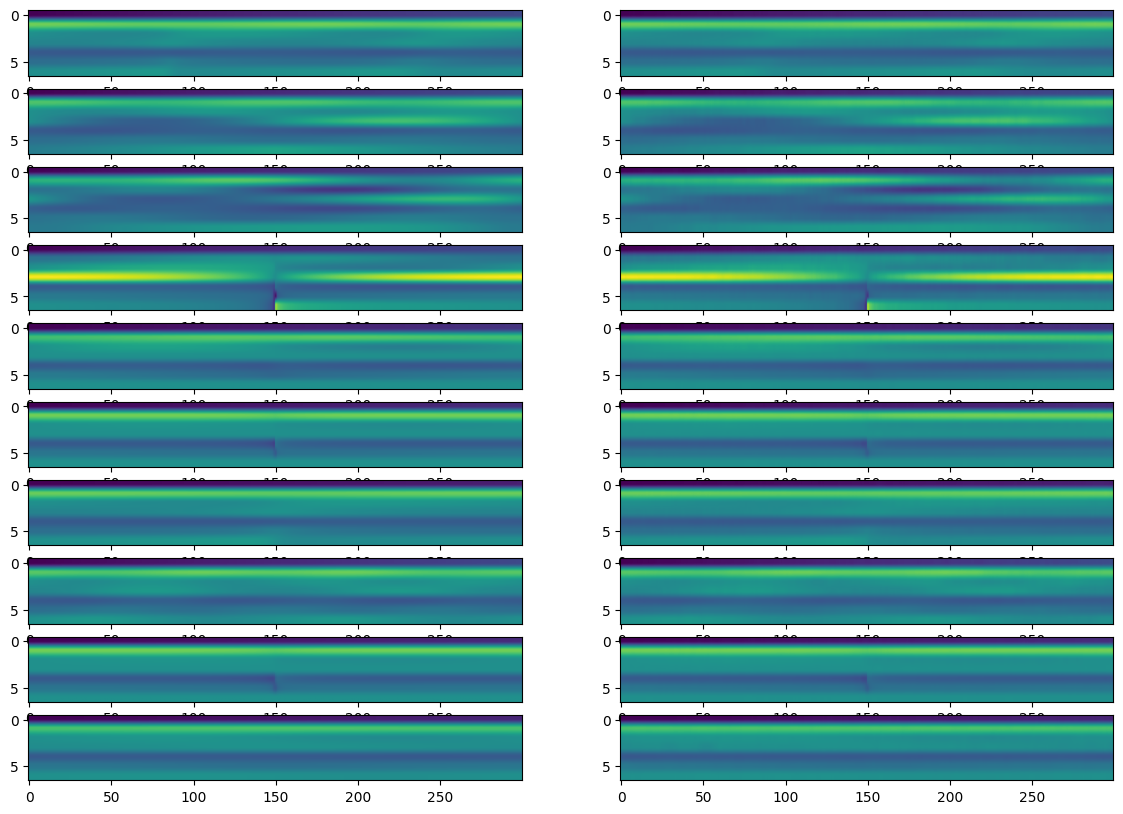

In [21]:
tsgm.utils.visualize_original_and_reconst_ts(scaled_data, x_decoded, num=10)

## Generate

In [22]:
generation = vae.generate(1000)
generation.shape

TensorShape([100, 300, 7])

In [33]:
inverted_generation = scaler.inverse_transform(generation)

In [26]:
np.save('generation.npy', inverted_generation)

In [34]:
no_time_generation = inverted_generation[:,:,1:]
no_time_generation.shape

TensorShape([100, 300, 6])

In [35]:
display_generation = np.transpose(no_time_generation, (0, 2, 1))

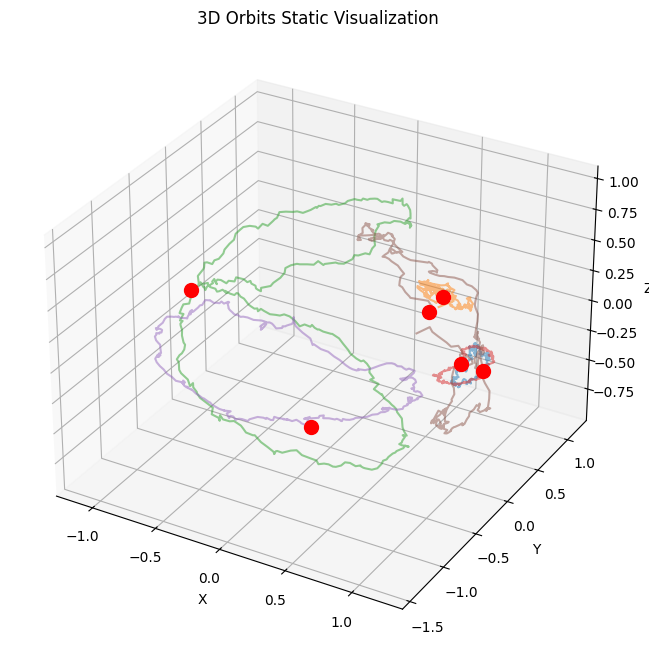

In [38]:
visualize_static_orbits(data= display_generation,time_instants=[0], orbit_indices=[0,10,20,30,40,50])

In [39]:
export_dynamic_orbits_html(data=display_generation)

Visualization saved to orbits.html


In [ ]:
latent_mean, _, _ = vae.encoder(scaled_data)
latent_representations = latent_mean.numpy()

In [ ]:
plot_latent_space(latent_representations, labels, n_colors=5, techniques=['All'])